# Identify Fixed LPR Camera Locations

**Objective:** Systematically identify parking lots with fixed LPR cameras using pattern analysis.

## Known Fixed Cameras (Ground Truth):
- **Lot 071** (stored as 71): Parking garage with entrance camera (CONFIRMED)
- **Lot 150**: Heavy lot with entrance camera (CONFIRMED)

## Fixed Camera Indicators:
1. **24/7 Operation**: Nighttime LPR activity (12am-6am)
2. **High LPR Frequency**: >60-70% of all hours have scans
3. **Consistent Patterns**: Low variance in scanning frequency
4. **Pattern Similarity**: Match patterns from known cameras (071, 150)
5. **No Gates**: Passive entrance/exit scanning only

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print('Fixed Camera Detection System Initialized')

Fixed Camera Detection System Initialized


## 1. Load LPR Data (Lot-Level Analysis)

Since fixed cameras are installed at specific lot entrances (not entire zones), we need to analyze by lot number.

In [39]:
# Load LPR data which has lot numbers
lpr = pd.read_csv('../data/processed/lpr_enriched.csv', parse_dates=['Date_Time'])

# Lot numbers are stored as integers in the data
KNOWN_FIXED_CAMERAS = [71, 150]  # Lots 071 and 150

print(f'LPR data: {len(lpr):,} scans')
print(f'Date range: {lpr["Date_Time"].min()} to {lpr["Date_Time"].max()}')
print(f'Lots: {lpr["Lot_number"].nunique()}')
print(f'\nKnown fixed cameras (lot numbers): {KNOWN_FIXED_CAMERAS}')

# Extract hour from timestamp
lpr['hour'] = lpr['Date_Time'].dt.hour
lpr['date'] = lpr['Date_Time'].dt.date

LPR data: 1,780,391 scans
Date range: 2022-07-01 05:24:26 to 2025-06-30 21:58:49
Lots: 185

Known fixed cameras (lot numbers): [71, 150]


## 2. Calculate LPR Frequency Metrics by Lot

In [40]:
# Group by lot number and calculate hourly stats
lot_stats = lpr.groupby('Lot_number').agg({
    'Date_Time': 'count',  # Total scans
    'date': 'nunique',  # Number of unique days
    'hour': 'count'  # For counting hours
}).rename(columns={'Date_Time': 'total_scans', 'date': 'unique_days', 'hour': 'total_hours'})

# Calculate hours with activity per lot
lot_hour_counts = lpr.groupby(['Lot_number', 'date', 'hour']).size().reset_index(name='scans')
total_possible_hours = lot_hour_counts.groupby('Lot_number').size()
lot_stats['total_possible_hours'] = total_possible_hours
lot_stats['hours_with_lpr'] = total_possible_hours
lot_stats['pct_hours_with_lpr'] = (lot_stats['hours_with_lpr'] / lot_stats['total_possible_hours'] * 100).fillna(0)

# Calculate coefficient of variation (consistency)
scans_per_hour = lot_hour_counts.groupby('Lot_number')['scans'].agg(['mean', 'std'])
lot_stats['avg_scans_per_hour'] = scans_per_hour['mean']
lot_stats['std_scans_per_hour'] = scans_per_hour['std']
lot_stats['lpr_cv'] = (lot_stats['std_scans_per_hour'] / lot_stats['avg_scans_per_hour']).fillna(0)

print('='*80)
print('LOT LPR FREQUENCY METRICS')
print('='*80)
print(lot_stats.sort_values('pct_hours_with_lpr', ascending=False).head(20))

LOT LPR FREQUENCY METRICS
            total_scans  unique_days  total_hours  total_possible_hours  \
Lot_number                                                                
1                 55868          368        55868                   585   
132                1292          197         1292                   251   
123                   5            3            5                     3   
124               95480          492        95480                   825   
125                  20            4           20                     4   
126                 345          201          345                   234   
127                  36           15           36                    15   
128                  76           22           76                    22   
129               23585          370        23585                   420   
130                6382          311         6382                   319   
131                4021          222         4021                   235   

## 3. Calculate Nighttime Activity (24/7 Indicator)

In [41]:
# Nighttime hours (12am-6am)
night_hours = lpr[lpr['hour'].between(0, 5)]

# Count nighttime hours with LPR activity per lot
night_lot_hour = night_hours.groupby(['Lot_number', 'date', 'hour']).size().reset_index(name='scans')
night_hours_with_lpr = night_lot_hour.groupby('Lot_number').size()

# Total possible nighttime hours (6 hours per day * number of days)
days_per_lot = lpr.groupby('Lot_number')['date'].nunique()
total_night_hours = days_per_lot * 6

lot_stats['night_hours_total'] = total_night_hours
lot_stats['night_hours_with_lpr'] = night_hours_with_lpr.reindex(lot_stats.index, fill_value=0)
lot_stats['pct_night_hours_with_lpr'] = (lot_stats['night_hours_with_lpr'] / lot_stats['night_hours_total'] * 100).fillna(0)

print('\n' + '='*80)
print('NIGHTTIME LPR ACTIVITY (12am-6am) BY LOT')
print('='*80)
print(lot_stats[['total_scans', 'pct_hours_with_lpr', 'pct_night_hours_with_lpr']].sort_values('pct_night_hours_with_lpr', ascending=False).head(20))


NIGHTTIME LPR ACTIVITY (12am-6am) BY LOT
            total_scans  pct_hours_with_lpr  pct_night_hours_with_lpr
Lot_number                                                           
71               120727               100.0                 10.702239
150              179363               100.0                  9.525994
156                   4               100.0                  8.333333
28                15289               100.0                  5.962521
137                2908               100.0                  5.921053
25                14166               100.0                  5.435435
155                 477               100.0                  4.814815
24                 8272               100.0                  4.345238
22                  264               100.0                  2.759382
29                 2126               100.0                  2.710496
30                 3485               100.0                  2.495544
48                   93               100.0     

## 4. Analyze Reference Patterns from Known Camera Lots


REFERENCE PATTERNS FROM KNOWN CAMERA LOTS
        071    150      avg
hour                       
0       119    113    116.0
1        80     39     59.5
2        31     12     21.5
3        20     10     15.0
4        76     90     83.0
5       729    630    679.5
6      1768   1300   1534.0
7      3848   6197   5022.5
8      7721  16707  12214.0
9      9949  21467  15708.0
10    12818  23557  18187.5
11    11712  20866  16289.0
12     9908  16191  13049.5
13    11479  20686  16082.5
14     9370  16559  12964.5
15     7180   9226   8203.0
16     7780   7390   7585.0
17     9044   7680   8362.0
18     7726   4797   6261.5
19     4697   2395   3546.0
20     2426   1509   1967.5
21     1300   1270   1285.0
22      680    363    521.5
23      266    309    287.5


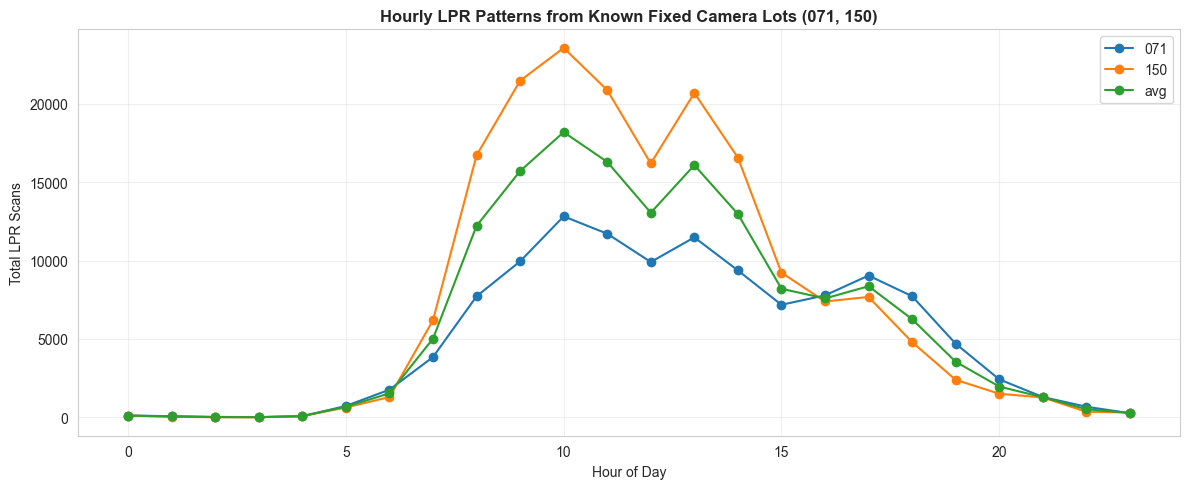

In [42]:
reference_lots = lpr[lpr['Lot_number'].isin(KNOWN_FIXED_CAMERAS)]

hourly_pattern_071 = reference_lots[reference_lots['Lot_number'] == 71].groupby('hour').size()
hourly_pattern_150 = reference_lots[reference_lots['Lot_number'] == 150].groupby('hour').size()

reference_pattern = pd.DataFrame({
    '071': hourly_pattern_071,
    '150': hourly_pattern_150
})

reference_pattern['avg'] = reference_pattern.mean(axis=1)

print('\n' + '='*80)
print('REFERENCE PATTERNS FROM KNOWN CAMERA LOTS')
print('='*80)
print(reference_pattern)

fig, ax = plt.subplots(figsize=(12, 5))
reference_pattern[['071', '150', 'avg']].plot(ax=ax, marker='o')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Total LPR Scans')
ax.set_title('Hourly LPR Patterns from Known Fixed Camera Lots (071, 150)', fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Calculate Pattern Similarity Scores by Lot

In [43]:
similarity_scores = {}

for lot in lpr['Lot_number'].unique():
    lot_data = lpr[lpr['Lot_number'] == lot]
    lot_pattern = lot_data.groupby('hour').size()
    
    # Need at least 12 hours of data for meaningful correlation
    if len(lot_pattern) >= 12:
        # Align the patterns (reindex to have all 24 hours)
        lot_pattern = lot_pattern.reindex(range(24), fill_value=0)
        ref_pattern = reference_pattern['avg'].reindex(range(24), fill_value=0)
        
        correlation = lot_pattern.corr(ref_pattern)
        similarity_scores[lot] = correlation if not pd.isna(correlation) else 0
    else:
        similarity_scores[lot] = 0

lot_stats['similarity_to_reference'] = pd.Series(similarity_scores)
lot_stats['similarity_to_reference'] = lot_stats['similarity_to_reference'].fillna(0).clip(lower=0)

print('\n' + '='*80)
print('TOP 20 LOTS BY SIMILARITY TO KNOWN CAMERA LOTS')
print('='*80)
print(lot_stats[['total_scans', 'pct_hours_with_lpr', 'pct_night_hours_with_lpr', 'similarity_to_reference']].sort_values('similarity_to_reference', ascending=False).head(20))


TOP 20 LOTS BY SIMILARITY TO KNOWN CAMERA LOTS
            total_scans  pct_hours_with_lpr  pct_night_hours_with_lpr  \
Lot_number                                                              
150              179363               100.0                  9.525994   
71               120727               100.0                 10.702239   
81                 3629               100.0                  0.472813   
85                 1990               100.0                  1.190476   
76                 8741               100.0                  0.381679   
146               88426               100.0                  0.000000   
32                38872               100.0                  1.265482   
75                  581               100.0                  0.154321   
70                23652               100.0                  0.000000   
181                 381               100.0                  0.123457   
2                 12298               100.0                  0.083126   
62 

## 6. Calculate Final Fixed Camera Confidence Scores by Lot

In [44]:
lot_stats['freq_score'] = (lot_stats['pct_hours_with_lpr'] / 100).clip(upper=1.0)
lot_stats['night_score'] = (lot_stats['pct_night_hours_with_lpr'] / 100).clip(upper=1.0)
lot_stats['consistency_score'] = (1 - lot_stats['lpr_cv'].clip(upper=2.0) / 2.0).clip(lower=0)

lot_stats['fixed_camera_score'] = (
    0.35 * lot_stats['similarity_to_reference'] +
    0.25 * lot_stats['freq_score'] +
    0.25 * lot_stats['night_score'] +
    0.15 * lot_stats['consistency_score']
) * 100

# Known cameras get 100% score
for known_camera in KNOWN_FIXED_CAMERAS:
    if known_camera in lot_stats.index:
        lot_stats.loc[known_camera, 'fixed_camera_score'] = 100.0

lot_stats['is_known_camera'] = lot_stats.index.isin(KNOWN_FIXED_CAMERAS)

lot_stats['camera_classification'] = 'MOBILE_PATROL'
lot_stats.loc[lot_stats['fixed_camera_score'] >= 70, 'camera_classification'] = 'FIXED_CAMERA_HIGH'
lot_stats.loc[lot_stats['fixed_camera_score'].between(50, 70), 'camera_classification'] = 'FIXED_CAMERA_MEDIUM'

print('\n' + '='*80)
print('FIXED CAMERA CONFIDENCE SCORES BY LOT')
print('='*80)
print('\nTop 20 Lots by Confidence Score:')
print(lot_stats[['fixed_camera_score', 'similarity_to_reference', 'pct_hours_with_lpr', 'pct_night_hours_with_lpr', 'camera_classification', 'is_known_camera']].sort_values('fixed_camera_score', ascending=False).head(20))

high_conf = (lot_stats['camera_classification'] == 'FIXED_CAMERA_HIGH').sum()
med_conf = (lot_stats['camera_classification'] == 'FIXED_CAMERA_MEDIUM').sum()

print('\n' + '='*80)
print('SUMMARY:')
print(f'  High confidence fixed camera lots: {high_conf}')
print(f'  Medium confidence: {med_conf}')
known_high = lot_stats[lot_stats["is_known_camera"]]["camera_classification"].value_counts().get("FIXED_CAMERA_HIGH", 0)
print(f'  Known cameras in high confidence: {known_high}')


FIXED CAMERA CONFIDENCE SCORES BY LOT

Top 20 Lots by Confidence Score:
            fixed_camera_score  similarity_to_reference  pct_hours_with_lpr  \
Lot_number                                                                    
150                 100.000000                 0.991129               100.0   
71                  100.000000                 0.969142               100.0   
85                   66.751719                 0.877135               100.0   
81                   66.671737                 0.905552               100.0   
146                  66.347909                 0.868235               100.0   
70                   65.212175                 0.848240               100.0   
76                   64.772489                 0.872660               100.0   
62                   64.726583                 0.839116               100.0   
2                    64.467104                 0.844726               100.0   
181                  64.346115                 0.848062   

## 7. Export Fixed Camera Classification by Lot

In [48]:
export_cols = ['total_scans', 'pct_hours_with_lpr', 'pct_night_hours_with_lpr', 'similarity_to_reference', 
               'avg_hours_per_day', 'avg_scans_per_active_hour', 'pct_high_activity_days', 
               'entrance_camera_score', 'bulk_patrol_score',
               'freq_score', 'night_score', 'consistency_score', 'temporal_score',
               'fixed_camera_score_v2', 'camera_classification_v2', 'is_known_camera']

lot_export = lot_stats[export_cols].copy()
lot_export['Lot_number'] = lot_export.index
lot_export = lot_export.sort_values('fixed_camera_score_v2', ascending=False)

output_file = '../data/processed/fixed_camera_classification.csv'
lot_export.to_csv(output_file, index=False)

print('\n' + '='*80)
print(f'EXPORTED: {output_file}')
print('='*80)
print(f'Total lots: {len(lot_export)}')
print('\nKnown camera lots:')
for camera in KNOWN_FIXED_CAMERAS:
    if camera in lot_stats.index:
        score = lot_stats.loc[camera, 'fixed_camera_score_v2']
        classification = lot_stats.loc[camera, 'camera_classification_v2']
        entrance_score = lot_stats.loc[camera, 'entrance_camera_score']
        avg_scans = lot_stats.loc[camera, 'avg_scans_per_active_hour']
        avg_hours = lot_stats.loc[camera, 'avg_hours_per_day']
        print(f'  LOT {camera}: {score:.1f}% ({classification})')
        print(f'    Entrance score: {entrance_score:.1f}%, Avg {avg_scans:.1f} scans/hr, {avg_hours:.1f} hrs/day')

print('\nNewly identified high-confidence camera lots:')
newly_identified = lot_export[(lot_export['camera_classification_v2'] == 'FIXED_CAMERA_HIGH') & (~lot_export['is_known_camera'])]
for idx, row in newly_identified.head(10).iterrows():
    print(f'  LOT {row["Lot_number"]}: {row["fixed_camera_score_v2"]:.1f}% (Entrance: {row["entrance_camera_score"]:.1f}%, Similarity: {row["similarity_to_reference"]:.2f})')



EXPORTED: ../data/processed/fixed_camera_classification.csv
Total lots: 185

Known camera lots:
  LOT 71: 100.0% (FIXED_CAMERA_HIGH)
    Entrance score: 88.1%, Avg 8.2 scans/hr, 13.6 hrs/day
  LOT 150: 100.0% (FIXED_CAMERA_HIGH)
    Entrance score: 84.4%, Avg 12.4 scans/hr, 13.3 hrs/day

Newly identified high-confidence camera lots:


## 8. Detect Sporadic vs Bulk LPR Patterns

**Fixed cameras** (entrance/exit): Sporadic individual scans as vehicles enter/exit randomly throughout the day
**Mobile patrols**: Bulk scans when patrol vehicle drives through - many vehicles scanned in short time window

In [46]:
# Analyze temporal patterns: sporadic vs bulk scanning
# Fixed cameras (entrance): Spread throughout day as people enter/exit randomly
# Mobile patrols: Concentrated bursts when patrol drives through

# For each lot, calculate:
# 1. Scan distribution throughout the day (fixed = more spread, patrol = clustered)
# 2. Average scans per hour with activity (fixed = lower, patrol = bulk)
# 3. Hours with LPR activity per day (fixed = more hours, patrol = fewer hours)

lot_temporal_patterns = []

for lot in lot_stats.index:
    lot_data = lpr[lpr['Lot_number'] == lot]
    
    # Group by date and hour
    hourly_scans = lot_data.groupby(['date', 'hour']).size()
    
    # Average scans per active hour (high = bulk patrol, low = sporadic entrance)
    avg_scans_per_active_hour = hourly_scans.mean() if len(hourly_scans) > 0 else 0
    
    # Coefficient of variation in hourly scans (high CV = inconsistent bulk, low CV = steady flow)
    hourly_scan_cv = (hourly_scans.std() / hourly_scans.mean()) if hourly_scans.mean() > 0 else 0
    
    # Count hours per day with activity
    daily_hour_counts = lot_data.groupby('date')['hour'].nunique()
    avg_hours_per_day = daily_hour_counts.mean() if len(daily_hour_counts) > 0 else 0
    
    # Days with many hours of activity (suggests entrance camera scanning throughout day)
    high_activity_days = (daily_hour_counts >= 8).sum()
    pct_high_activity_days = (high_activity_days / len(daily_hour_counts) * 100) if len(daily_hour_counts) > 0 else 0
    
    # Days with only 1-2 hours of activity (suggests quick patrol pass)
    low_activity_days = (daily_hour_counts <= 2).sum()
    pct_low_activity_days = (low_activity_days / len(daily_hour_counts) * 100) if len(daily_hour_counts) > 0 else 0
    
    lot_temporal_patterns.append({
        'Lot_number': lot,
        'avg_scans_per_active_hour': avg_scans_per_active_hour,
        'hourly_scan_cv': hourly_scan_cv,
        'avg_hours_per_day': avg_hours_per_day,
        'pct_high_activity_days': pct_high_activity_days,
        'pct_low_activity_days': pct_low_activity_days
    })

temporal_df = pd.DataFrame(lot_temporal_patterns).set_index('Lot_number')

# Drop existing temporal columns if they exist
temporal_cols = ['avg_scans_per_active_hour', 'hourly_scan_cv', 'avg_hours_per_day', 
                 'pct_high_activity_days', 'pct_low_activity_days', 'entrance_camera_score', 
                 'bulk_patrol_score', 'temporal_score']
lot_stats = lot_stats.drop(columns=[c for c in temporal_cols if c in lot_stats.columns], errors='ignore')

# Merge with lot_stats
lot_stats = lot_stats.join(temporal_df)

# Create "entrance camera" score (higher = more likely fixed entrance camera)
# Fixed cameras: Many hours/day, lower scans/hour (sporadic), high % of days with long activity
lot_stats['entrance_camera_score'] = (
    0.4 * (lot_stats['pct_high_activity_days'] / 100) +
    0.3 * (lot_stats['avg_hours_per_day'].clip(upper=15) / 15) +
    0.3 * (1 - lot_stats['avg_scans_per_active_hour'].clip(upper=50) / 50)
) * 100

# Bulk patrol score (inverse)
lot_stats['bulk_patrol_score'] = 100 - lot_stats['entrance_camera_score']

print('='*80)
print('TEMPORAL PATTERN ANALYSIS: Sporadic Entrance vs Bulk Patrol')
print('='*80)
print('\nMost BULK PATROL patterns (concentrated scans):')
print(lot_stats[['avg_scans_per_active_hour', 'avg_hours_per_day', 'pct_low_activity_days', 'bulk_patrol_score']].sort_values('bulk_patrol_score', ascending=False).head(15))

print('\n\nMost ENTRANCE CAMERA patterns (spread throughout day):')
print(lot_stats[['avg_scans_per_active_hour', 'avg_hours_per_day', 'pct_high_activity_days', 'entrance_camera_score']].sort_values('entrance_camera_score', ascending=False).head(15))

print('\n\nKnown camera lots (071=71, 150):')
for cam in KNOWN_FIXED_CAMERAS:
    if cam in lot_stats.index:
        print(f"  LOT {cam}:")
        print(f"    Avg scans per active hour: {lot_stats.loc[cam, 'avg_scans_per_active_hour']:.1f}")
        print(f"    Avg hours/day: {lot_stats.loc[cam, 'avg_hours_per_day']:.1f}")
        print(f"    High activity days: {lot_stats.loc[cam, 'pct_high_activity_days']:.1f}%")
        print(f"    Entrance camera score: {lot_stats.loc[cam, 'entrance_camera_score']:.1f}%")


TEMPORAL PATTERN ANALYSIS: Sporadic Entrance vs Bulk Patrol

Most BULK PATROL patterns (concentrated scans):
            avg_scans_per_active_hour  avg_hours_per_day  \
Lot_number                                                 
113                         57.376147           1.123711   
47                          88.383673           1.123853   
92                          51.406250           1.126761   
129                         56.154762           1.135135   
134                         61.148847           1.157767   
164                         62.515244           1.184116   
139                         59.655172           1.235795   
38                          78.343811           1.288608   
160                         81.312618           1.324190   
177                         62.439560           1.358209   
104                         86.912752           1.555324   
1                           95.500855           1.589674   
124                        115.733333           1.6

## 9. Revised Fixed Camera Scoring (with Temporal Patterns)

In [49]:
# Recalculate fixed camera score with temporal patterns
# Key indicators:
# 1. Entrance camera pattern (sporadic scans throughout many hours)
# 2. High nighttime activity (24/7 operation)
# 3. High pattern similarity to known cameras
# 4. High frequency and consistency

# Normalize entrance camera score to 0-1
lot_stats['temporal_score'] = (lot_stats['entrance_camera_score'] / 100).clip(upper=1.0)

# Recalculate with temporal component
lot_stats['fixed_camera_score_v2'] = (
    0.30 * lot_stats['temporal_score'] +           # NEW: Entrance camera pattern
    0.25 * lot_stats['similarity_to_reference'] +
    0.20 * lot_stats['freq_score'] +
    0.15 * lot_stats['night_score'] +
    0.10 * lot_stats['consistency_score']
) * 100

# Known cameras still get 100%
for known_camera in KNOWN_FIXED_CAMERAS:
    if known_camera in lot_stats.index:
        lot_stats.loc[known_camera, 'fixed_camera_score_v2'] = 100.0

# Reclassify based on new scores
lot_stats['camera_classification_v2'] = 'MOBILE_PATROL'
lot_stats.loc[lot_stats['fixed_camera_score_v2'] >= 70, 'camera_classification_v2'] = 'FIXED_CAMERA_HIGH'
lot_stats.loc[lot_stats['fixed_camera_score_v2'].between(50, 70), 'camera_classification_v2'] = 'FIXED_CAMERA_MEDIUM'

print('='*80)
print('REVISED FIXED CAMERA CONFIDENCE SCORES (with temporal analysis)')
print('='*80)
print('\nTop 20 Lots by Revised Confidence Score:')
top_lots = lot_stats[['fixed_camera_score_v2', 'temporal_score', 'similarity_to_reference', 
                       'pct_night_hours_with_lpr', 'avg_hours_per_day', 'avg_scans_per_active_hour',
                       'camera_classification_v2', 'is_known_camera']].sort_values('fixed_camera_score_v2', ascending=False).head(20)
print(top_lots)

high_conf_v2 = (lot_stats['camera_classification_v2'] == 'FIXED_CAMERA_HIGH').sum()
med_conf_v2 = (lot_stats['camera_classification_v2'] == 'FIXED_CAMERA_MEDIUM').sum()

print('\n' + '='*80)
print('REVISED SUMMARY:')
print(f'  High confidence fixed camera lots: {high_conf_v2}')
print(f'  Medium confidence: {med_conf_v2}')
known_high_v2 = lot_stats[lot_stats["is_known_camera"]]["camera_classification_v2"].value_counts().get("FIXED_CAMERA_HIGH", 0)
print(f'  Known cameras in high confidence: {known_high_v2}')

print('\n\nNewly identified HIGH confidence camera lots:')
newly_identified_v2 = lot_stats[(lot_stats['camera_classification_v2'] == 'FIXED_CAMERA_HIGH') & 
                                 (~lot_stats['is_known_camera'])]
for lot in newly_identified_v2.index:
    score = lot_stats.loc[lot, 'fixed_camera_score_v2']
    temporal = lot_stats.loc[lot, 'temporal_score'] * 100
    similarity = lot_stats.loc[lot, 'similarity_to_reference'] * 100
    avg_hours = lot_stats.loc[lot, 'avg_hours_per_day']
    avg_scans_hr = lot_stats.loc[lot, 'avg_scans_per_active_hour']
    print(f'  LOT {lot}: {score:.1f}% (Temporal: {temporal:.1f}%, Similarity: {similarity:.1f}%, Avg {avg_hours:.1f} hrs/day, {avg_scans_hr:.1f} scans/hr)')


REVISED FIXED CAMERA CONFIDENCE SCORES (with temporal analysis)

Top 20 Lots by Revised Confidence Score:
            fixed_camera_score_v2  temporal_score  similarity_to_reference  \
Lot_number                                                                   
71                     100.000000        0.881023                 0.969142   
150                    100.000000        0.843619                 0.991129   
85                      58.422923        0.304880                 0.877135   
81                      58.154667        0.295738                 0.905552   
62                      57.506524        0.320787                 0.839116   
181                     57.021318        0.312640                 0.848062   
75                      55.919884        0.298419                 0.858409   
76                      55.306425        0.244779                 0.872660   
97                      54.740598        0.322702                 0.827514   
174                     54.694031   